In [1]:
import torch
import os
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn.functional as F
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
image_size = 28*28
batch_size = 128
num_epochs = 30
latent_dim = 100
num_classes = 10

OUTPUT_DIR = "./data/cgan"

# Load Data

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 3169786.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 488444.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4447209.71it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5358798.53it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

# Model

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, noise, context):
        noise = noise.view(-1, latent_dim)
        context_feature = self.label_emb(context)
        x = torch.cat([noise, context_feature], 1)

        return self.model(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(image_size + num_classes, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, context):
        img = img.view(-1, image_size)
        context_feature = self.label_emb(context)

        x = torch.cat((img, context_feature), dim=1)
        return self.model(x)

# Train

In [7]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=1e-4)

# Loss function
criterion = nn.BCELoss()

In [8]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        real_images, labels = images.to(device), labels.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # --------- Train the Teacher (D) --------- #
        d_optimizer.zero_grad()
        outputs = discriminator(real_images, labels)
        d_real_loss = criterion(outputs, real_labels)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z, labels)
        outputs = discriminator(fake_images, labels)
        d_fake_loss = criterion(outputs, fake_labels)

        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optimizer.step()

        # --------- Train the Student (G) --------- #
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z, labels)
        outputs = discriminator(fake_images, labels)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 400 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

    # Save generated images every epoch
    save_image(fake_images.reshape(fake_images.size(0), 1, 28, 28), './data/cgan/fake_image-%03d.png' % (epoch+1))

print("Training complete.")

Epoch [1/100], Step [400/468], D Loss: 0.6759669780731201, G Loss: 3.613382339477539
Epoch [2/100], Step [400/468], D Loss: 1.1352248191833496, G Loss: 2.035966396331787
Epoch [3/100], Step [400/468], D Loss: 0.4300110340118408, G Loss: 2.8700218200683594
Epoch [4/100], Step [400/468], D Loss: 0.12287019193172455, G Loss: 5.34199333190918
Epoch [5/100], Step [400/468], D Loss: 0.1315767914056778, G Loss: 4.697266101837158
Epoch [6/100], Step [400/468], D Loss: 0.260549396276474, G Loss: 4.208713531494141
Epoch [7/100], Step [400/468], D Loss: 0.15665501356124878, G Loss: 4.41027307510376
Epoch [8/100], Step [400/468], D Loss: 0.19694998860359192, G Loss: 4.545169353485107
Epoch [9/100], Step [400/468], D Loss: 0.1129409670829773, G Loss: 5.688512802124023
Epoch [10/100], Step [400/468], D Loss: 0.14861173927783966, G Loss: 5.696250915527344
Epoch [11/100], Step [400/468], D Loss: 0.1609121859073639, G Loss: 5.515410900115967
Epoch [12/100], Step [400/468], D Loss: 0.1455863118171692, G

# Test

In [9]:
for label in range(10):
    z = torch.randn(batch_size, latent_dim).to(device)
    labels = torch.full((batch_size,), label, device=device, dtype=torch.long)
    fake_images = generator(z, labels)

    save_image(fake_images.reshape(fake_images.size(0), 1, 28, 28), os.path.join(OUTPUT_DIR, f'result-{label}.png'))

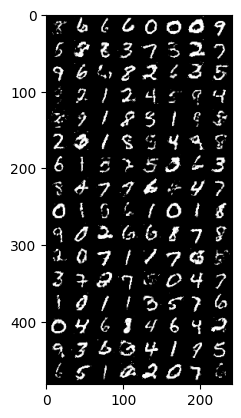

In [10]:
image = Image.open(OUTPUT_DIR + "/result-0.png")
plt.imshow(image)
plt.show()

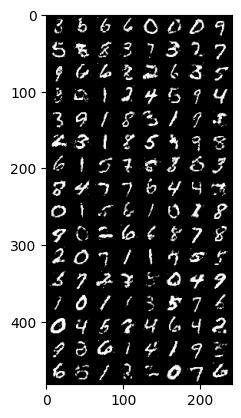

In [11]:
image = Image.open(OUTPUT_DIR + "/result-1.png")
plt.imshow(image)
plt.show()

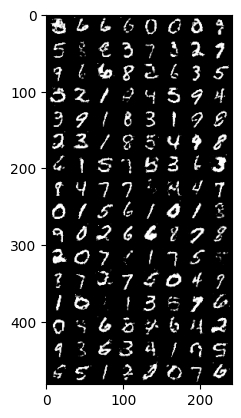

In [12]:
image = Image.open(OUTPUT_DIR + "/result-2.png")
plt.imshow(image)
plt.show()

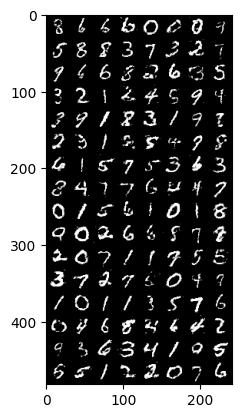

In [13]:
image = Image.open(OUTPUT_DIR + "/result-3.png")
plt.imshow(image)
plt.show()

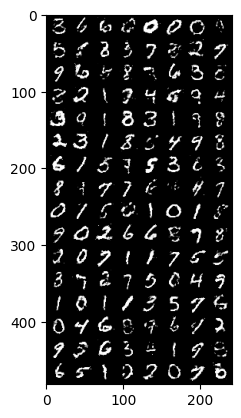

In [14]:
image = Image.open(OUTPUT_DIR + "/result-4.png")
plt.imshow(image)
plt.show()

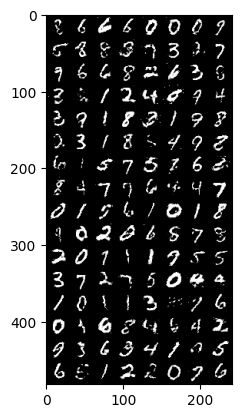

In [15]:
image = Image.open(OUTPUT_DIR + "/result-5.png")
plt.imshow(image)
plt.show()

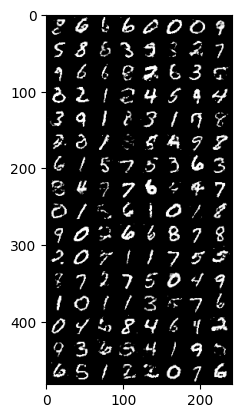

In [16]:
image = Image.open(OUTPUT_DIR + "/result-6.png")
plt.imshow(image)
plt.show()

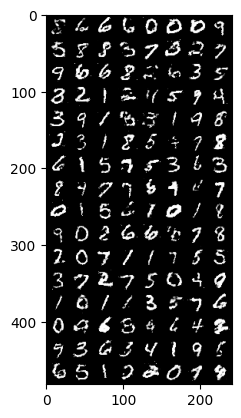

In [17]:
image = Image.open(OUTPUT_DIR + "/result-7.png")
plt.imshow(image)
plt.show()

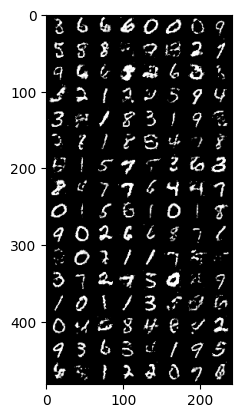

In [18]:
image = Image.open(OUTPUT_DIR + "/result-8.png")
plt.imshow(image)
plt.show()

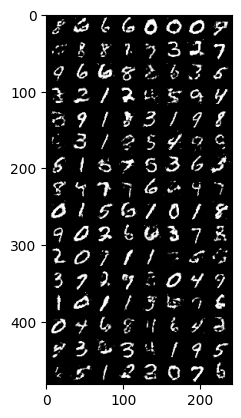

In [19]:
image = Image.open(OUTPUT_DIR + "/result-9.png")
plt.imshow(image)
plt.show()